# Simulation for a Hysteresis Loop for <font color=red>Multiple Layers (Auto) </font>

### Composite magnet with <font color=blue>hard/soft/hard layers</font>
- Magnetic hard layers: Nd$_2$Fe$_{14}$B magnets
* Magnetic soft layers: $\alpha$-Fe

## Define geometry region and mesh cells: <font color=red>Hard/Soft/Hard 3 layer structure</font>

In [1]:
import oommfc as mc

import discretisedfield as df
import micromagneticmodel as mm
import numpy as np

length = 250e-9  # Length of entire magnet
width = 250e-9  # width of entire magnet
h_phase1 = 47.5e-9 # height of each layer of the 1st phase, such as magnetically hard phase
h_phase2 = 30e-9   # height of each layer of the 2nd phase, such as magnetically soft phase

cell = (5e-9, 5e-9, 2.5e-9)
# n = (31, 31, 10)
# Define layer thickness of each layer
#layer_thickness = [h_phase1,h_phase2,h_phase1,h_phase2,h_phase1,h_phase2,h_phase1,h_phase2,h_phase1]
layer_thickness = [h_phase1,h_phase2,h_phase1]

# Define the phase of each layers
# 2: magnetically hard phase
# 0: magnetically soft phase
# 1: magnetically 3rd phase (for example: semi-hard phase)
# layer_phase = [2, 0, 2, 0, 2, 0, 2,0,2]
layer_phase = [2, 0, 2]
# Define material objects: Materials: Hard -> Nd 2 Fe 14 B; Soft ->  𝛼 -Fe
# Define material intrinsice properties
## Magnetization of different phases
Ms_h = 1.28e6 # NdFeB
Ms_s = 1.75e6  #Fe
Ms_3rd = 0 # 3rd phase
## Exchange constant
A_h = 7.7e-12  # NdFeB
A_s = 20.0e-12  #Fe
A_3rd = 0 # 3rd phase
A_s_h = 20.0e-12  #between two phase
## Magnetocrystalline anisotropy constant
K_h=4.331e6    #  NdFeB
K_s = 2.0e5   #  Fe
K_3rd = 0 # 3rd phase


subregions = {}
MsNorm={}
Adict={}
Kdict={}
phase_color = np.ones(len(layer_thickness));
phase_color.astype(int)

x_origin = - length/2.0
y_origin = - width/2.0
z_origin = - sum(layer_thickness)/2.0

all_layer_name = [""]*len(layer_thickness)

for i in range(len(layer_thickness)):
    layer_name = "Layer_{:02d}".format(i)
    all_layer_name[i] = layer_name
    subregions[layer_name] = df.Region(p1=(x_origin,y_origin, z_origin+sum(layer_thickness[0:i])), 
                                       p2=(x_origin+length,y_origin+width, z_origin+sum(layer_thickness[0:i+1])))
    if layer_phase[i] == 2:
        MsNorm[layer_name] = Ms_h
        Adict[layer_name] = A_h
        Kdict[layer_name] = K_h
        phase_color[i] = 255 # blue
    elif layer_phase[i] == 0:
        MsNorm[layer_name] = Ms_s
        Adict[layer_name] = A_s
        Kdict[layer_name] = K_s
        phase_color[i] = 16711680 # red
    elif layer_phase[i] == 1:
        MsNorm[layer_name] = Ms_3rd
        Adict[layer_name] = A_3rd
        Kdict[layer_name] = K_3rd
        phase_color[i] = 65025 # green

for i in range(len(all_layer_name)-1):
    Adict[all_layer_name[i]+":"+all_layer_name[i+1]] = A_s_h
    
p1 = (x_origin,y_origin, z_origin)
p2 = (x_origin+length,y_origin+width, z_origin+sum(layer_thickness))
mesh = df.Mesh(p1=p1, p2=p2, cell=cell, subregions=subregions,bc='x')

# display regions/sub-regions
mesh.k3d_subregions(color=phase_color) # ,opacity=0.7)


Output()

/srv/conda/envs/notebook/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "uint32". A coerced copy has been created.
  warnings.warn(


In [2]:
print(Adict)

{'Layer_00': 7.7e-12, 'Layer_01': 2e-11, 'Layer_02': 7.7e-12, 'Layer_00:Layer_01': 2e-11, 'Layer_01:Layer_02': 2e-11}


## Core simulation
- #### Define material objects: <font color=red>Materials: Hard -> Nd$_2$Fe$_{14}$B; Soft -> $\alpha$-Fe</font>  
- #### Define the energy system: <font color=red>Anisotropy, exchange, magnetostatic, Zeeman energies</font>  
- #### Define hysteresis loops:  <font color=red>Control of external field </font>  

In [3]:
system = mm.System(name='composite_magnet_multilayers')

# Define hysteresis loops: Control of external field: Unit is Tesla (T)
H_range = list(np.arange(4.0, 1.0, -1.0)) + list(np.arange(0.8, -0.8, -0.2)) + list(np.arange(-1.0,-5.0,-0.1)) + list(np.arange(-5.2,-7.0,-0.2))
#H_range = list(np.arange(0, -2, -0.5)) + list(np.arange(-2.2,-4.0,-0.2))

# Storage for simulated magnetiztion Jx, Jy, Jz:
Jx=[None]*len(H_range)
Jy=[None]*len(H_range)
Jz=[None]*len(H_range)

In [4]:
# Calculate hysteresis loops through Control of external field 
for i in range(len(H_range)):
    H = (0, 0, H_range[i]/mm.consts.mu0)  # external magnetic field (A/m), 
    system.energy = mm.Exchange(A=Adict) + mm.UniaxialAnisotropy(K=Kdict, u=(0.00001, 0, 1)) + mm.Zeeman(H=H)  + mm.Demag()
    system.m = df.Field(mesh, dim=3, value=(0, 0, 1), norm=MsNorm)
    
    # system driver 
    md = mc.MinDriver()
    md.drive(system)

    Jx[i]=system.table.data.mx.values[0]
    Jy[i]=system.table.data.my.values[0]
    Jz[i]=system.table.data.mz.values[0]
    
    #write ".omf" file
    ovffilename = "Composite_Magnet_MultiLayer-H={:7.3f}T.omf".format(H_range[i])
    #display(ovffilename)
    system.m.write(ovffilename)

Running OOMMF (ExeOOMMFRunner) [2020/10/14 21:27]... (19.1 s)
Running OOMMF (ExeOOMMFRunner) [2020/10/14 21:28]... (20.6 s)
Running OOMMF (ExeOOMMFRunner) [2020/10/14 21:29]... (73.3 s)
Running OOMMF (ExeOOMMFRunner) [2020/10/14 21:31]... (68.7 s)
Running OOMMF (ExeOOMMFRunner) [2020/10/14 21:33]... (57.3 s)
Running OOMMF (ExeOOMMFRunner) [2020/10/14 21:35]... (54.5 s)
Running OOMMF (ExeOOMMFRunner) [2020/10/14 21:37]... (54.4 s)
Running OOMMF (ExeOOMMFRunner) [2020/10/14 21:39]... (53.5 s)
Running OOMMF (ExeOOMMFRunner) [2020/10/14 21:40]... (52.0 s)
Running OOMMF (ExeOOMMFRunner) [2020/10/14 21:42]... (58.4 s)
Running OOMMF (ExeOOMMFRunner) [2020/10/14 21:44]... (65.9 s)
Running OOMMF (ExeOOMMFRunner) [2020/10/14 21:46]... (69.0 s)
Running OOMMF (ExeOOMMFRunner) [2020/10/14 21:48]... (63.9 s)
Running OOMMF (ExeOOMMFRunner) [2020/10/14 21:50]... (65.7 s)
Running OOMMF (ExeOOMMFRunner) [2020/10/14 21:52]... (56.1 s)
Running OOMMF (ExeOOMMFRunner) [2020/10/14 21:54]... (54.4 s)
Running 

## Save data file <font color=red>hysteresis curve</font>  

In [5]:
import csv  
    
# field names  
fields = ['Field H', 'Jx', 'Jy', 'Jz']  
# data rows of csv file  
rows = [H_range, Jx, Jy, Jz ]  
# name of csv file  
filename = "test.csv"
    
# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)  
    # writing the fields  
    csvwriter.writerow(fields)  
    # writing the data rows  
    csvwriter.writerows(rows) 

## Display <font color=red>Simulated Results</font>  

#### Display <font color=blue>hysteresis curve</font>  

<Figure size 576x432 with 0 Axes>

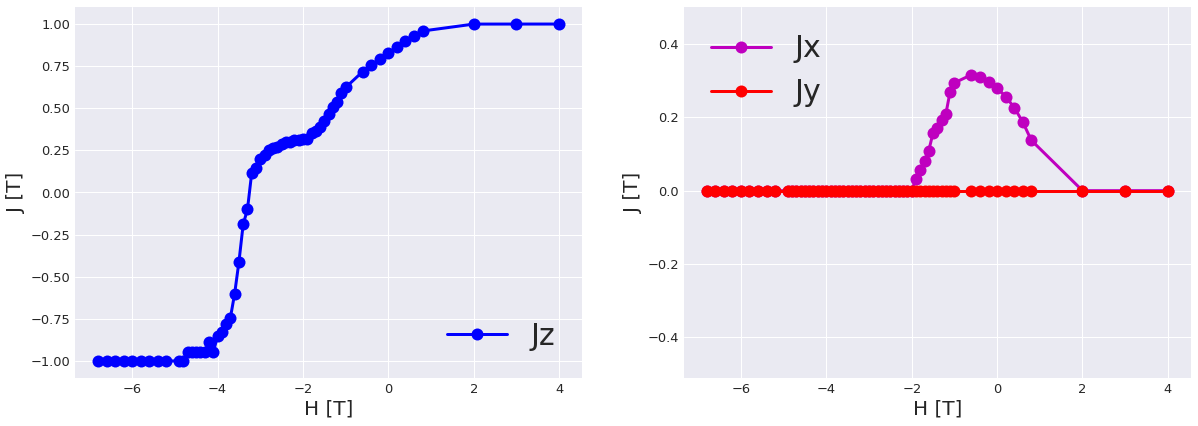

In [6]:
import matplotlib.pyplot as plt
plt.figure();
fig = plt.figure(figsize=(20, 15));
ax1=fig.add_subplot(2,2,1);
ax2=fig.add_subplot(2,2,2);
#ax = fig.gca()

# Customise the axes
ax1.set_xlabel('H [T]',fontsize=20)
ax1.set_ylabel('J [T]',fontsize=20)
ax1.set_ylim(ymin=-1.1,ymax=1.1)
ax1.grid()
ax1.plot(H_range,Jz,'bo-',label='Jz',linewidth=3,markersize=12)
ax1.legend(loc='lower right',fontsize=30)

ax2.set_xlabel('H [T]',fontsize=20)
ax2.set_ylabel('J [T]',fontsize=20)
ax2.set_ylim(ymin=-0.51,ymax=0.5)
ax2.grid()
ax2.plot(H_range,Jx,'mo-',label='Jx',linewidth=3,markersize=12)
ax2.plot(H_range,Jy,'ro-',label='Jy',linewidth=3,markersize=12)
ax2.legend(loc='upper left',fontsize=30);


#### Display <font color=blue>magnetic distribution (topview)</font>  

In [7]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider

@interact(i=IntSlider(description='Field #',value=0,min=0,max=len(H_range)-1,step=1, 
                      continuous_update=False,layout={'width': '400px'}),
          z=system.m.mesh.slider('z',  continuous_update=False,layout={'width': '400px'}))
def slice_plot_topview(i,z):
    ovffilename = "Composite_Magnet_MultiLayer-H={:7.3f}T.omf".format(H_range[i])
    display(ovffilename)
    field = df.Field.fromfile(ovffilename)   
    field.plane(z=z).mpl(ax=None,figsize=(15, 10), vector_scale=0.8e8,scalar_colorbar=True, scalar_colorbar_label='M_z',
                            scalar_cmap='rainbow',scalar_clim=[-0.9*max(Ms_h,Ms_s),0.9*max(Ms_h,Ms_s)],
                             vector_field=field)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Field #', layout=Layout(width='…

#### Display <font color=blue>magnetic distribution (cross-section)</font>  

In [10]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider

@interact(i=IntSlider(description='Field #',min=0,max=len(H_range)-1,step=1, continuous_update=False,layout={'width': '400px'}),
          y=system.m.mesh.slider('y', continuous_update=False,layout={'width': '400px'}))
def f(i,y=0):
    ovffilename = "Composite_Magnet_MultiLayer-H={:7.3f}T.omf".format(H_range[i])
    display(ovffilename)
    field_read = df.Field.fromfile(ovffilename)
    field_read.plane(y=y).mpl(figsize=(15, 10), scalar_field = field_read.z,
                            scalar_cmap='rainbow',scalar_clim=[-0.9*max(Ms_h,Ms_s),0.9*max(Ms_h,Ms_s)],
                            scalar_colorbar=True, scalar_colorbar_label='M_z',multiplier=1e-6,
                            vector_field=field_read,vector_scale=0.9e8,)
    return 

interactive(children=(IntSlider(value=0, continuous_update=False, description='Field #', layout=Layout(width='…

In [9]:
# # Open selected saved field file
def openfile_dialog():
    from PyQt5 import QtGui
    from PyQt5 import QtGui, QtWidgets
    app = QtWidgets.QApplication([dir])
    fname,_filter = QtWidgets.QFileDialog.getOpenFileName(None, "Select a file...", '.', filter="All files (*)")
    return str(fname)
filename = openfile_dialog()
import os
ovffilename = os.path.basename(filename)
display(ovffilename)
# # display field distribution
field_read = df.Field.fromfile(ovffilename)

@df.interact(y=system.m.mesh.slider('y', continuous_update=False))
def my_plot(y):
    #system.m.plane(y=y).mpl(figsize=(20, 20), vector_scale=1e8 )
    #field_read.plane(y=y).mpl(figsize=(10, 10))
    field_read.plane(y=y).mpl_vector(figsize=(15, 8), color_field=field_read.z,cmap='rainbow',clim=[-0.9*max(Ms_h,Ms_s),0.9*max(Ms_h,Ms_s)])

ModuleNotFoundError: No module named 'PyQt5'

## Save data file <font color=red>hysteresis curve</font>  

In [ ]:
import csv  
    
# field names  
fields = ['Field H', 'Jx', 'Jy', 'Jz']  
# data rows of csv file  
rows = [H_range, Jx, Jy, Jz ]  
# name of csv file  
filename = "test.csv"
    
# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)  
    # writing the fields  
    csvwriter.writerow(fields)  
    # writing the data rows  
    csvwriter.writerows(rows) 

## backup scripts <font color=red>3D plots</font>  
* #### Plot slices along different direction and location

In [ ]:
import k3d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider

@interact(i=IntSlider(description='Field #',value=0,min=0,max=len(H_range)-1,step=1, continuous_update=False,layout={'width': '400px'}),
          y=system.m.mesh.slider('y',  continuous_update=False,layout={'width': '400px'}),
          z1=system.m.mesh.slider('z', description='z1', continuous_update=False,layout={'width': '400px'}),
          z2=system.m.mesh.slider('z', description='z2', continuous_update=False,layout={'width': '400px'}))
#          z3=system.m.mesh.slider('z', description='z3', continuous_update=False,layout={'width': '400px'}))
def f(i,y, z1, z2):
    ovffilename = "Composite_Magnet_MultiLayer-H={:7.3f}T.omf".format(H_range[i])
    display(ovffilename)
    field_read = df.Field.fromfile(ovffilename)    
    plot = k3d.plot();
    #display(field_read.plane)

    field_read.z.plane(y=y).k3d_scalar(plot=plot,multiplier=None,cmap='rainbow',
                                       clim=[-0.9*max(Ms_h,Ms_s),0.9*max(Ms_h,Ms_s)])
    field_read.z.plane(z=z1).k3d_scalar(plot=plot,multiplier=None,cmap='rainbow',clim=[-0.9*max(Ms_h,Ms_s),0.9*max(Ms_h,Ms_s)])
    field_read.z.plane(z=z2).k3d_scalar(plot=plot,multiplier=None,cmap='rainbow',clim=[-0.9*max(Ms_h,Ms_s),0.9*max(Ms_h,Ms_s)])
#    field_read.z.plane(z=z3).k3d_scalar(plot=plot,filter_field=field_read.plane(z=z3).z,multiplier=None,cmap='rainbow',clim=[-0.9*max(Ms_h,Ms_s),0.9*max(Ms_h,Ms_s)])
    plot.display()
    return 